# Training and testing of the XLNet model on the train dataset (Reddit book reviews)

In [18]:
from transformers import DataCollatorWithPadding,TrainingArguments, Trainer, AutoTokenizer, XLNetForSequenceClassification
from datasets import load_dataset
from huggingface_hub import notebook_login
import numpy as np
import evaluate
import torch._dynamo
from scipy.special import softmax
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import time


In [2]:
torch.manual_seed(42)

In [3]:
train_dataset = load_dataset("csv", data_files="books_train.csv")["train"]
test_dataset = load_dataset("csv", data_files="books_test.csv")["train"]

In [4]:
tokenizer = AutoTokenizer.from_pretrained('xlnet/xlnet-base-cased')

In [5]:
device = torch.device('cpu')
torch.set_num_threads(16)

In [6]:
def preprocess_function(examples):
    inputs = tokenizer(examples["body"], truncation=True).to(device)
    return inputs
 
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

In [7]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [8]:
model = XLNetForSequenceClassification.from_pretrained('xlnet/xlnet-base-cased', num_labels=2).to(device)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Safetensors PR exists


## Identifying the metrics for training the model

In [9]:
def compute_metrics(eval_pred):
   load_precision = evaluate.load("precision")
   load_f1 = evaluate.load("f1")
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   precision = load_precision.compute(predictions=predictions, references=labels)
   f1 = load_f1.compute(predictions=predictions, references=labels)
   return {"precision": precision, "f1": f1}


In [10]:
repo_name = "finetuning-XLNET-Reddit-books"
training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=1,
   per_device_eval_batch_size=1,
   num_train_epochs=3.6,
   weight_decay=0.05,
   # max_steps = 10,
   save_strategy="no",
   push_to_hub=False,
   logging_steps=10,  # Print loss every 10 steps
   log_level="info",
   no_cuda=True
)
 
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


/home/demomaks/python_environments/anya/lib/python3.12/site-packages/transformers/training_args.py:1590: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
/tmp/ipykernel_19223/1565871068.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: body. If body are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 200
  Num Epochs = 4
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 720
  Number of trainable parameters = 117,310,466


Step,Training Loss
10,0.992800
20,0.717800
30,0.678000
40,0.780800
50,1.575800
60,1.551100
70,2.206100
80,1.696500
90,1.669500
100,1.914400




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=720, training_loss=0.8482370738591676, metrics={'train_runtime': 1291.9411, 'train_samples_per_second': 0.557, 'train_steps_per_second': 0.557, 'total_flos': 122537468683080.0, 'train_loss': 0.8482370738591676, 'epoch': 3.6})

In [12]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: body. If body are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'eval_loss': 0.9831397533416748,
 'eval_precision': {'precision': 0.9041095890410958},
 'eval_f1': {'f1': 0.9103448275862069},
 'eval_runtime': 80.1192,
 'eval_samples_per_second': 1.248,
 'eval_steps_per_second': 1.248,
 'epoch': 3.6}

## Calculating accuracy

In [13]:
logits_list = []
data = test_dataset['body']
batch_size = 2

for start in range(0, len(data), batch_size):
    print("Processing " + str(start))
    batch = data[start:start + batch_size]
    # tokenize all first?
    inputs = tokenizer(batch, truncation=True, return_tensors="pt", padding=True).to("cpu")
    with torch.no_grad():
        logits_list.append(model(**inputs).logits)
logits = torch.cat(logits_list)

predictions = np.argmax(logits, axis=-1)
labels = test_dataset["label"]
load_accuracy = evaluate.load("accuracy")
accuracy = load_accuracy.compute(predictions=predictions, references=labels)
print({"accuracy": accuracy})

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Processing 0
Processing 2
Processing 4
Processing 6
Processing 8
Processing 10
Processing 12
Processing 14
Processing 16
Processing 18
Processing 20
Processing 22
Processing 24
Processing 26
Processing 28
Processing 30
Processing 32
Processing 34
Processing 36
Processing 38
Processing 40
Processing 42
Processing 44
Processing 46
Processing 48
Processing 50
Processing 52
Processing 54
Processing 56
Processing 58
Processing 60
Processing 62
Processing 64
Processing 66
Processing 68
Processing 70
Processing 72
Processing 74
Processing 76
Processing 78
Processing 80
Processing 82
Processing 84
Processing 86
Processing 88
Processing 90
Processing 92
Processing 94
Processing 96
Processing 98
{'accuracy': {'accuracy': 0.87}}


## Precision is 0.90, F1 is 0.91, accuracy is 87

In [15]:
#logits of the inference on the testing data
Reddit_xlnet_logits = logits.cpu().numpy()

## PR curve: calculating precision and recall

In [20]:
y_true = np.array(test_dataset["label"])
Reddit_xlnet_precision = []
Reddit_xlnet_recall = []
Reddit_xlnet_probabilities = softmax(Reddit_xlnet_logits, axis=1)
threshold = list(np.arange(0.0, 1, 0.001))
for t in threshold:
    y_scores = (Reddit_xlnet_probabilities[:, 1] > t).astype(int)
    Reddit_xlnet_precision.append(precision_score(y_true, y_scores, zero_division=1))
    Reddit_xlnet_recall.append(recall_score(y_true, y_scores, zero_division=1))

Reddit_xlnet_precision.append(1)
Reddit_xlnet_recall.append(0)

## Baseline model which always returns the most frequent class

In [21]:
y_score_baseline = np.ones(y_true.shape)
baseline_precision = precision_score(y_true, y_score_baseline, zero_division=1)
baseline_recall = recall_score(y_true, y_score_baseline, zero_division=1)

## Plotting the PR curve

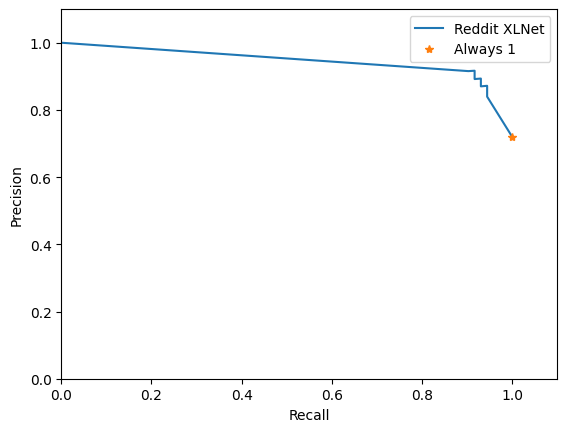

In [24]:
fig, ax = plt.subplots()
ax.plot(Reddit_xlnet_recall, Reddit_xlnet_precision, '-', label='Reddit XLNet')
ax.plot([baseline_recall], [baseline_precision], '*', label='Always 1')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim((0, 1.1))
ax.set_ylim((0, 1.1))
ax.legend()

In [25]:
np.savetxt("Reddit_xlnet_logits.csv", Reddit_xlnet_logits, delimiter = ",")

## Estimating inference time

In [27]:
model_cpu = model.to("cpu")
time_start = time.perf_counter()

for text in test_dataset["body"]:
        request = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to('cpu')
        outputs = model_cpu(**request)

time_end = time.perf_counter()
    
print(f'Took {(time_end - time_start):.3f} seconds')

Took 91.505 seconds
